In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# -----------------------------
# 2. Config
# -----------------------------
DATA_DIR = r"D:\Download\data\PoseEstimation\NTU\nturgb+d_skeletons"
EPOCHS = 1
BATCH_SIZE = 32
LR = 1e-3
SEQ_LEN = 30      # số frame lấy cho mỗi sample
INPUT_SIZE = 75   # 25 joints * 3 tọa độ
HIDDEN_SIZE = 128
NUM_LAYERS = 6
NUM_CLASSES = 6
MODEL_PATH = r"D:\code_etc\Python\_File_code\Pose_estimation\1_epochs_36.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# -----------------------------
# 3. Dataset class
# -----------------------------
class NTUSkeletonDataset(Dataset):
    def __init__(self, data_dir, seq_len=30):
        self.samples = []
        self.labels = []
        self.seq_len = seq_len

        # map từ tên class sang nhãn
        self.class_map = {
            "lying": 0,
            "walking": 1,
            "standing": 2,
            "jumping": 3,
            "running": 4,
            "carrying": 5,
        }

        # duyệt toàn bộ file .skeleton
        for fname in os.listdir(data_dir):
            if not fname.endswith(".skeleton"):
                continue

            # lấy action ID từ tên file
            # Format: S001C001P001R001A001.skeleton → A001 = action ID
            action_id = int(fname.split("A")[1][:3])

            # chọn 6 class theo action ID
            label = self.map_action_to_label(action_id)
            if label is None:
                continue

            fpath = os.path.join(data_dir, fname)
            data = self.parse_skeleton_file(fpath)

            if len(data) >= self.seq_len:
                # lấy ngẫu nhiên 1 đoạn seq_len frame
                start = random.randint(0, len(data) - self.seq_len)
                clip = data[start:start+self.seq_len]
                self.samples.append(clip)
                self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X = np.array(self.samples[idx], dtype=np.float32)   # (seq_len, 75)
        y = self.labels[idx]
        return torch.tensor(X), torch.tensor(y)

    def parse_skeleton_file(self, path):
        frames = []
        with open(path, 'r') as f:
            num_frames = int(f.readline())
            for _ in range(num_frames):
                num_bodies = int(f.readline())
                joints = []
                for _ in range(num_bodies):
                    _ = f.readline()  # skip body info
                    num_joints = int(f.readline())
                    for _ in range(num_joints):
                        x, y, z, *_ = map(float, f.readline().split())
                        joints.extend([x, y, z])
                if len(joints) >= 75:
                    frames.append(joints[:75])  # chỉ lấy 25 khớp đầu
        return frames

    def map_action_to_label(self, action_id):
        # mapping ID → 6 class (tham khảo NTU action list)
        lying_ids = [15, 79]       # ví dụ: lying down, lying
        walking_ids = [2, 55]      # walking
        standing_ids = [1, 48]     # standing up / still
        jumping_ids = [26, 46]     # jumping
        running_ids = [3, 19]      # running
        carrying_ids = [50, 51]    # carrying

        if action_id in lying_ids:
            return self.class_map["lying"]
        elif action_id in walking_ids:
            return self.class_map["walking"]
        elif action_id in standing_ids:
            return self.class_map["standing"]
        elif action_id in jumping_ids:
            return self.class_map["jumping"]
        elif action_id in running_ids:
            return self.class_map["running"]
        elif action_id in carrying_ids:
            return self.class_map["carrying"]
        else:
            return None

In [4]:
# -----------------------------
# 4. Model
# -----------------------------
class ActionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ActionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the last hidden state
        out = self.fc(out)
        return out

In [5]:
dataset = NTUSkeletonDataset(DATA_DIR, seq_len=SEQ_LEN)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [10]:
# Load lại model với kiến trúc cũ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = ActionLSTM(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=2,       # LSTM 2 layers (giống lúc train)
    num_classes=NUM_CLASSES
).to(device)

# Load weight
checkpoint_path = r"D:\code_etc\Python\_File_code\Pose_estimation\50_epochs_pe.pth"
loaded_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
loaded_model.eval()

print(f"✅ Model loaded from {checkpoint_path}")

✅ Model loaded from D:\code_etc\Python\_File_code\Pose_estimation\50_epochs_pe.pth


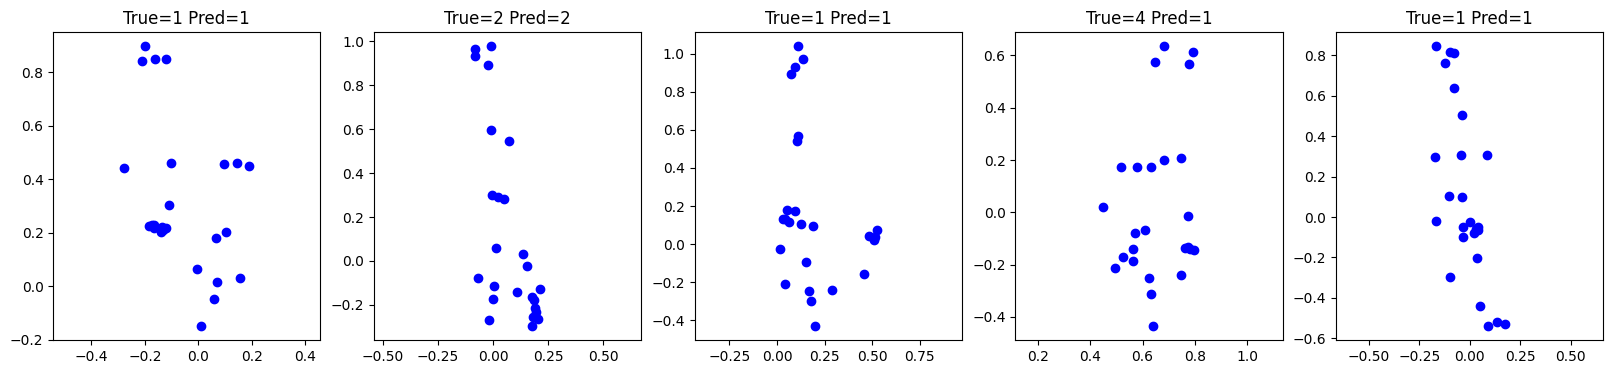

In [11]:
# --- Hàm vẽ skeleton tự động nhận 2D hoặc 3D ---
def plot_skeleton(pose_vector, ax, title=""):
    n_elements = pose_vector.shape[0]

    if n_elements % 3 == 0:
        coords = pose_vector.reshape(-1, 3)  # (num_joints, 3)
    elif n_elements % 2 == 0:
        coords = pose_vector.reshape(-1, 2)  # (num_joints, 2)
    else:
        raise ValueError(f"pose_vector không chia hết cho 2 hoặc 3 (size={n_elements})")

    x, y = coords[:, 0], coords[:, 1]
    ax.scatter(x, -y, c="blue")  # -y để hiển thị đúng hướng
    ax.set_title(title)
    ax.axis("equal")

# --- Lấy 5 mẫu ngẫu nhiên từ tập val ---
val_samples = [val_ds[i] for i in random.sample(range(len(val_ds)), 5)]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, (X, y) in enumerate(val_samples):
    X = X.unsqueeze(0).to(device)  # thêm batch dim
    with torch.no_grad():
        outputs = loaded_model(X)
        _, pred = outputs.max(1)

    # lấy frame cuối cùng của sequence
    pose_vec = X[0, -1, :].cpu().numpy()
    true_label, pred_label = y.item(), pred.item()
    title = f"True={true_label} Pred={pred_label}"

    plot_skeleton(pose_vec, axes[i], title=title)

plt.show()

F1 score: 0.7086


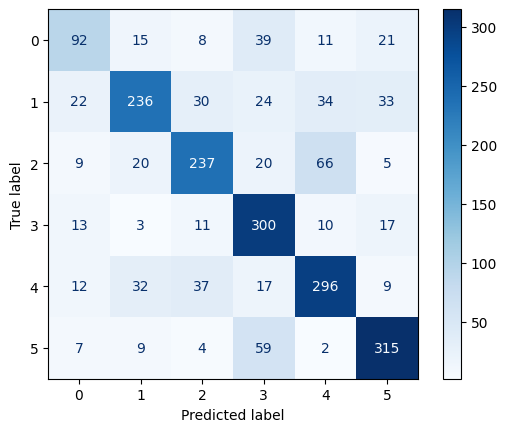

In [9]:
# --- Hàm tính dự đoán và nhãn thực ---
all_preds = []
all_labels = []

loaded_model.eval()
with torch.no_grad():
    for X, y in val_ds:  # lặp qua toàn bộ tập validation
        X = X.unsqueeze(0).to(device)
        outputs = loaded_model(X)
        _, pred = outputs.max(1)

        all_preds.append(pred.item())
        all_labels.append(y.item())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# --- Tính F1 score ---
f1 = f1_score(all_labels, all_preds, average='weighted')  # hoặc 'macro', 'micro'
print(f"F1 score: {f1:.4f}")

# --- Confusion matrix ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()